# SageMaker Ground Truth and Object Detection
## Workshop Guide

### Table of contents
1. [Introduction to dataset](#introduction)
2. [Labeling with SageMaker Ground Truth](#groundtruth)
3. [Reviewing labeling results](#review)
4. [Training an Object Detection model](#training)
5. [Review of Training Results](#review_training)
6. [Model Tuning](#model_tuning)
7. [Cleanup](#cleanup)


### Bootstrap embedded images

Download images used in the rest of this guide

In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()
BUCKET = sess.default_bucket()
PREFIX = 'input'

arn:aws:iam::732099549710:role/service-role/AmazonSageMaker-ExecutionRole-20210408T171218
CPU times: user 957 ms, sys: 177 ms, total: 1.13 s
Wall time: 6.09 s


Then reload the notebook (close/reopen for JupyterLab) so that the instruction images in the rest of this notebook become visible.

<a name="introduction"></a>
## Introduction to dataset
In this workshop we will use a dataset from the [inaturalist.org](inaturalist.org) This dataset contains 500 images of bees that have been uploaded by inaturalist users for the purposes of recording the observation and identification. We only used images that their users have licensed under [CC0](https://creativecommons.org/share-your-work/public-domain/cc0/) license. For your convenience, we have placed the dataset in S3 in a single zip archive here: http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip 

First, download and unzip the archive.

In [2]:
!wget http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip 
!unzip -qo dataset.zip

--2021-04-19 21:20:02--  http://aws-tc-largeobjects.s3-us-west-2.amazonaws.com/DIG-TF-200-MLBEES-10-EN/dataset.zip
Resolving aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)... 52.218.182.169
Connecting to aws-tc-largeobjects.s3-us-west-2.amazonaws.com (aws-tc-largeobjects.s3-us-west-2.amazonaws.com)|52.218.182.169|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70375947 (67M) [application/x-zip-compressed]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  67.12M  5.58MB/s    in 11s     

2021-04-19 21:20:14 (5.91 MB/s) - ‘dataset.zip’ saved [70375947/70375947]



The archive contains the following structure: 500 `.jpg` image files, a manifest file (to be explained later) and 10 test images in the `test` subfolder.

In [3]:
!unzip -l dataset.zip | tail -20

   251027  05-15-2019 19:21   9530124.jpg
   110561  05-15-2019 19:21   9542264.jpg
   312354  05-15-2019 19:21   9543188.jpg
    76903  05-15-2019 19:21   9637165.jpg
    48663  05-15-2019 19:21   9765741.jpg
    66393  05-15-2019 19:21   9787032.jpg
   273392  05-22-2019 21:58   output.manifest
        0  06-01-2019 05:51   test/
    83438  06-01-2019 05:51   test/22427594.jpg
   152133  06-01-2019 05:51   test/22469656.jpg
   205930  06-01-2019 05:51   test/22544384.jpg
   137755  06-01-2019 05:51   test/22673445.jpg
   124565  06-01-2019 05:51   test/22741822.jpg
    39502  06-01-2019 05:51   test/22774999.jpg
    39086  06-01-2019 05:51   test/22775000.jpg
   149389  06-01-2019 05:51   test/22901964.jpg
   103322  06-01-2019 05:51   test/22971237.jpg
   109178  06-01-2019 05:51   test/23086755.jpg
---------                     -------
 70635014                     512 files


Now let's upload this dataset to your own S3 bucket in preparation for labeling and training using Amazon SageMaker. For this workshop we will be using `us-west-2` region, so your bucket needs to be in this region. 

In [4]:
!aws s3 sync --exclude="*" --include="[0-9]*.jpg" . s3://$BUCKET/$PREFIX/

upload: ./10006450.jpg to s3://sagemaker-us-east-1-732099549710/input/10006450.jpg   
upload: ./10250726.jpg to s3://sagemaker-us-east-1-732099549710/input/10250726.jpg   
upload: ./1063563.jpg to s3://sagemaker-us-east-1-732099549710/input/1063563.jpg    
upload: ./10022723.jpg to s3://sagemaker-us-east-1-732099549710/input/10022723.jpg  
upload: ./10059108.jpg to s3://sagemaker-us-east-1-732099549710/input/10059108.jpg  
upload: ./10299519.jpg to s3://sagemaker-us-east-1-732099549710/input/10299519.jpg   
upload: ./10437385.jpg to s3://sagemaker-us-east-1-732099549710/input/10437385.jpg    
upload: ./10632489.jpg to s3://sagemaker-us-east-1-732099549710/input/10632489.jpg    
upload: ./10937818.jpg to s3://sagemaker-us-east-1-732099549710/input/10937818.jpg    
upload: ./1060304.jpg to s3://sagemaker-us-east-1-732099549710/input/1060304.jpg    
upload: ./10311147.jpg to s3://sagemaker-us-east-1-732099549710/input/10311147.jpg  
upload: ./10551061.jpg to s3://sagemaker-us-east-1-73209

## Labeling with SageMaker Ground Truth <a name="groundtruth"></a>

Now, we are ready to run your first labeling with Amazon SageMaker Ground Truth. We have already labeled the larger dataset, and you will be using this labeled dataset to train your model. This exercise is meant to only demonstrate how you would use SageMaker Ground Truth to label your own datasets, so you will only get label  small sample labeled. Below we walk through the four steps for creating and kicking off a labeling job. 

### Step 1: Navigate to the SageMaker Ground Truth console.

In the AWS Management Console, navigate to Amazon SageMaker and then select 'Labeling jobs' option under the 'Ground Truth' menu. Remember to make sure you are in the Oregon region.

<img src="guide/Tutorial-Step1a.png" width="600" border="3">

To kick off a Labeling, click the 'Create labeling job' button.

<img src="guide/Tutorial-Step1b.png" width="600" border="3">


### Step 2: Set up input and output dataset locations

Let's begin by giving a name to the labeling job. Since this labeling job is only meant to be a sample, let's name it 'Sample-labeling-job'. 

Then, let's give the path to the input dataset location. A labeling job takes an input manifest as the input dataset. An input manifest effectively points to the dataset objects in the dataset.

<img src="guide/Tutorial-Step2a.png" width="600" border="3">

Realize that we have not yet created the input manifest. Instead above, we only uploaded 500 images. Fortunately, SageMaker Ground Truth provides a cool feature that creates the input manifest for you. 

To use this feature, first select 'Automated data setup', then click on the 'Complete Data Setup' link and provide the path to the uploaded images. 

Then, select 'Image' as the 'Data type'. 

Then, we will provide the IAM Role that allows SageMaker Ground Truth to read and write to your S3 locations. The easiest option is 'Create a new role' and specifically provide access to the your S3 bucket.

There are currently 500 images in our input dataset. We do not want to send all 500 images to the labeling job (for time and cost reasons). Instead, we want to randomly sample 2% of the images (or 10 images). SageMaker Ground Truth makes it easy to perform this sampling.

Click on 'Additional configuration', and click on the 'Random sample' option. Next, indicate you want to sample 2% of the dataset. Then to complete the process, click on 'Create subset'. This will create a new input manifest, and once it is created, click 'Use this subset'. 

<img src="guide/Tutorial-Step2d.png" width="500" border="3">

Make sure to click on the "Use this subset" button once the subset has been created.





### Step 3: Select task type and worker type

Under 'Task type', select the 'Bounding box' option. To complete this step, click 'Next' at the bottom of the page.

<img src="guide/Tutorial-Step3a.png" width="500" border="3">

For this labeling job, we want to use the **'Private'** worker option. This option will direct the labeling job to an internally defined workforce. For the purposes of this workshop we will use our own contact details to set ourselves up as the workforce. 

<img src="guide/Tutorial-Private.png" width="600" border="3">

### Step 4: Create the task instructions

This is the most important step as it will directly impact the accuracy of the labels generated. We have discussed this topic in-depth in this blog post: https://aws.amazon.com/blogs/machine-learning/create-high-quality-instructions-for-amazon-sagemaker-ground-truth-labeling-jobs/

Start with your primary call-to-action in the header; here we use: "Draw a bounding box around the bee in this image." Then, let's define the label category on the right-hand side. This is "bee" in our case. 

Next, we want to provide visual examples of both good and bad labels. We have pre-created these examples, and you can directly insert these examples by clicking on the image icon and then pointing to the below public URLs:

Good Example - https://s3.us-west-2.amazonaws.com/sagemaker-remars/bee-good-5535715.jpg 

Bad Example - https://s3.us-west-2.amazonaws.com/sagemaker-remars/bee-bad-5535715.jpg

Then, we suggest providing some helper text to guide the workers for both good and bad examples. Once done select the "Preview" button if you like to view the page presented to the workers.

<img src="guide/Tutorial-Step4a.png" width="600" border="3">


### Labeling

By now you should have received an email inviting you to log into the labeling UI. Click on the link provided and login - you will be asked to change your password. Once in, start labeling.

<img src="guide/Turorial-PrivateEmail.png" width="600" border="3">

If instead of Private workforce you chose Public, the labeling will be performed by the Amazon Mechanical Turk public workforce, which is globally distributed, 24/7 available. With the public workforce it may take some time before all images are labeled even if it's a small subset.

## Reviewing labeling results
<a name="reviewing"></a>

**WARNING: Pick OPTION 1 or OPTION 2 cells below**

If your labeling job has not finished (in case you chose the Public workforce), we can review results of the previously completed labeling job called ```bees-500``` using the provided augmented manifest file ```output.manifest```. In that case run OPTION 1 cell below and skip OPTION 2. Otherwise, skip OPTION 1 and run OPTION 2 to use results of your own labeling job.

In [5]:
###########
# OPTION 1: provided labeling results
###########
labeling_job_name = 'bees-500'
augmented_manifest_file = 'output.manifest'

###########
### OPTION 2: your own labeling job completed
###########
### Enter the name of your job here

```python

labeling_job_name = 'Sample-labeling-job'

import boto3
client = boto3.client('sagemaker')

s3_output_path = client.describe_labeling_job(LabelingJobName=labeling_job_name)['OutputConfig']['S3OutputPath'].rstrip('/')
augmented_manifest_url = f'{s3_output_path}/{labeling_job_name}/manifests/output/output.manifest'

import os
import shutil

try:
    os.makedirs('od_output_data/', exist_ok=False)
except FileExistsError:
    shutil.rmtree('od_output_data/')

# now download the augmented manifest file and display first 3 lines
!aws s3 cp $augmented_manifest_url od_output_data/
augmented_manifest_file = 'od_output_data/output.manifest'

```

Let's see the first few lines of the manifest file

In [6]:
#replacing bucket name and prefix to right format
outputManifest = open("output.manifest", "rt")
#read file contents to string
manifest = outputManifest.read()
#replace all occurrences of the required string
replaceStr = BUCKET + '/' + PREFIX
manifest = manifest.replace('sagemaker-remars/datasets/na-bees/500', replaceStr)
#close the input file
outputManifest.close()
#open the input file in write mode
outputManifest = open("output.manifest", "wt")
#overrite the input file with the resulting data
outputManifest.write(manifest)
#close the file
outputManifest.close()

In [7]:
!head -3 $augmented_manifest_file

{"source-ref":"s3://sagemaker-us-east-1-732099549710/input/10006450.jpg","bees-500":{"annotations":[{"class_id":0,"width":95.39999999999998,"top":256.2,"height":86.80000000000001,"left":177}],"image_size":[{"width":500,"depth":3,"height":500}]},"bees-500-metadata":{"job-name":"labeling-job/bees-500","class-map":{"0":"bee"},"human-annotated":"yes","objects":[{"confidence":0.75}],"creation-date":"2019-05-16T00:15:58.914553","type":"groundtruth/object-detection"}}
{"source-ref":"s3://sagemaker-us-east-1-732099549710/input/10022723.jpg","bees-500":{"annotations":[{"class_id":0,"width":93.8,"top":228.8,"height":135,"left":126.8}],"image_size":[{"width":375,"depth":3,"height":500}]},"bees-500-metadata":{"job-name":"labeling-job/bees-500","class-map":{"0":"bee"},"human-annotated":"yes","objects":[{"confidence":0.82}],"creation-date":"2019-05-16T00:41:33.384412","type":"groundtruth/object-detection"}}
{"source-ref":"s3://sagemaker-us-east-1-732099549710/input/10059108.jpg","bees-500":{"annotat

Now let's plot all the annotated images. First, let's define a function that displays the local image file and draws over it the bounding boxes obtained via labeling.

In [8]:
import os
import boto3
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from itertools import cycle

def show_annotated_image(img_path, bboxes):
    im = np.array(Image.open(img_path), dtype=np.uint8)
    
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    colors = cycle(['r', 'g', 'b', 'y', 'c', 'm', 'k', 'w'])
    
    for bbox in bboxes:
        # Create a Rectangle patch
        rect = patches.Rectangle((bbox['left'],bbox['top']),bbox['width'],bbox['height'],linewidth=1,edgecolor=next(colors),facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

Next, read the augmented manifest (JSON lines format) line by line and display the first 10 images.

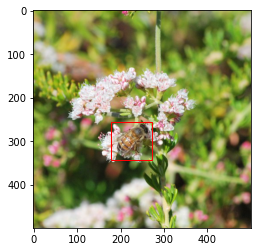

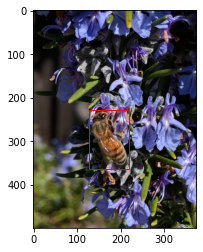

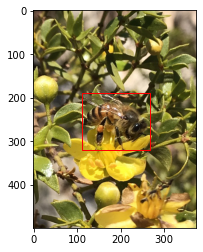

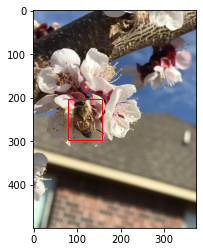

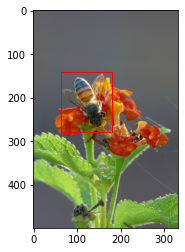

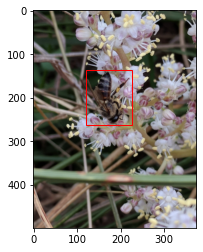

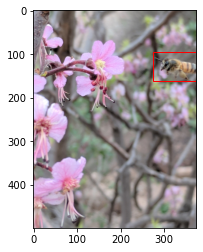

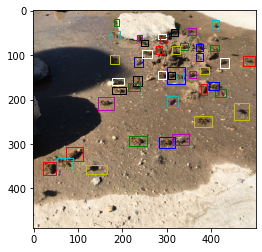

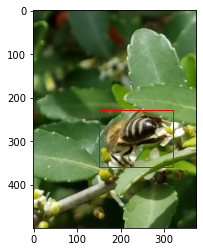

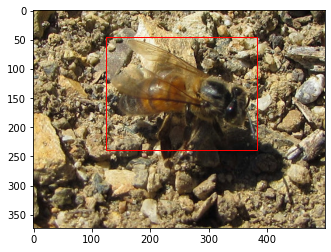

In [9]:
!pip -q install --upgrade pip
!pip -q install jsonlines
import jsonlines
from itertools import islice

with jsonlines.open(augmented_manifest_file, 'r') as reader:
    for desc in islice(reader, 10):
        img_url = desc['source-ref']
        img_file = os.path.basename(img_url)
        file_exists = os.path.isfile(img_file)

        bboxes = desc[labeling_job_name]['annotations']
        show_annotated_image(img_file, bboxes)

<a name='training'></a>
## Training an Object Detection Model
We are now ready to use the labeled dataset in order to train a Machine Learning model using the SageMaker [built-in Object Detection algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html).

For this, we would need to split the full labeled dataset into a training and a validation datasets. Out of the total of 500 images we are going to use 400 for training and 100 for validation. The algorithm will use the first one to train the model and the latter to estimate the accuracy of the model, trained so far. The augmented manifest file from the previously run full labeling job was included in the original zip archive as `output.manifest`.

In [10]:
import json

with jsonlines.open('output.manifest', 'r') as reader:
    lines = list(reader)
    # Shuffle data in place.
    np.random.shuffle(lines)
    
dataset_size = len(lines)
num_training_samples = round(dataset_size*0.8)

train_data = lines[:num_training_samples]
validation_data = lines[num_training_samples:]

augmented_manifest_filename_train = 'train.manifest'

with open(augmented_manifest_filename_train, 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')

augmented_manifest_filename_validation = 'validation.manifest'

with open(augmented_manifest_filename_validation, 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')
        
print(f'training samples: {num_training_samples}, validation samples: {len(lines)-num_training_samples}')

training samples: 400, validation samples: 100


Next, let's upload the two manifest files to S3 in preparation for training. We will use the same bucket you created earlier.

In [11]:
pfx_training = PREFIX + '/training' if PREFIX else 'training'
# Defines paths for use in the training job request.
s3_train_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_train)
s3_validation_data_path = 's3://{}/{}/{}'.format(BUCKET, pfx_training, augmented_manifest_filename_validation)

!aws s3 cp train.manifest s3://$BUCKET/$pfx_training/
!aws s3 cp validation.manifest s3://$BUCKET/$pfx_training/

upload: ./train.manifest to s3://sagemaker-us-east-1-732099549710/input/training/train.manifest
upload: ./validation.manifest to s3://sagemaker-us-east-1-732099549710/input/training/validation.manifest



<a name='console'></a>

### Console option

#### Step 1: SageMaker Training Job wizard

First, click on the "Training Jobs" link in the SageMaker Nav bar.

<img src="guide/nav_training_jobs.png" width="300" border="3">

Then, click on "Create training job" button.

<img src="guide/create_training_job.png" width="800" border="3">

#### Step 2: Enter basic details

Next, enter training job name, e.g. `bees-detection-resnet`, create or select an existing role, leave the default `Amazon SageMaker built-in algorithm` and choose `Object Detection` from the drop-down.

<img src="guide/job_details_1.png" width="600" border="3">

Scroll down to select Pipe input mode (data is streamed from S3) and pick the `ml.g4dn.xlarge` instance for training.

<img src="guide/job_details_2.png" width="600" border="3">

#### Step 3: Hyperparameters

Scroll down even further to specify algorithm hyperparameters. The meaning of hyperparameters is available in [SageMaker documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection-api-config.html). First, we are going to select `resnet-50` instead of the default `vgg-16` for the `base_network`, then select `1` (means true) for `use_pretrained_model` (we will start with a pretrained model), enter 1 for `num_classes` (we only have one class - bees), choose `100` for the number of training `epochs` and change `mini_batch_size` to `1` (one image per batch).

<img src="guide/job_details_3.png" width="600" border="3">

Keep scrolling to specify more hyperparameters. Enter the `num_training_samples` - it was 400 for our dataset. Then fill the remaining hyperparameters related to early stopping condition as shown below. This means that we might stop training even before the 100 epochs are completed (but not earlier than 50 epochs) when the validation accuracy metric mAP fails to improve by 0.01 in 5 epochs.

<img src="guide/job_details_4.png" width="600" border="3">

#### Step 4: Specify training/validation datasets

Next, let's specify where the training algorithm will read the training and validation datasets (aka channels). Fill in the information as shown in the screenshots below. The S3 location of manifests files should be the same that you used above when uploading them to S3 - replace `s3://sagemaker-remars/training/` with your own prefix.

<img src="guide/job_details_5.png" width="500" border="3">

Click `Add Channel` in order to add a validation channel. Make sure to type the name `validation` in the `Channel name` box.

<img src="guide/job_details_6.png" width="500" border="3">

#### Step 5: Kick off the training job

Now, let's specify the S3 output location where the training algorithm will save the trained model artifacts. Once again your bucket and prefix will be different. Finally, click the `Create training job` button to start the training!

<img src="guide/job_details_7.png" width="800" border="3">


In [44]:
train_input = {
    "ChannelName": "train",
    "InputMode" : "Pipe",
    "DataSource": {
        "S3DataSource": {
            "S3DataType": "AugmentedManifestFile",  
            "S3Uri": s3_train_data_path,
            "S3DataDistributionType": "FullyReplicated",
            "AttributeNames": ['source-ref', 'bees-500']
        }
    },
    "RecordWrapperType": "RecordIO",
    "CompressionType": "None"
}

validation_input = {
    "ChannelName": "validation",
    "InputMode" : "Pipe",
    "DataSource": {
        "S3DataSource": {
            "S3DataType": "AugmentedManifestFile",  
            "S3Uri": s3_validation_data_path,
            "S3DataDistributionType": "FullyReplicated",
            "AttributeNames": ['source-ref', 'bees-500']
        }
    },
    "RecordWrapperType": "RecordIO",
    "CompressionType": "None"
}

s3_output_path = 's3://{}/{}/output'.format(BUCKET, pfx_training)

In [36]:
# train_input = sagemaker.inputs.TrainingInput(s3_data = s3_train_data_path,
#                               distribution = "FullyReplicated",
#                               compression = "None",
#                               record_wrapping = "RecordIO",
#                               s3_data_type = "AugmentedManifestFile",
#                               input_mode = "Pipe",
#                               attribute_names = ['source-ref', 'bees-500'])

# validation_input = sagemaker.inputs.TrainingInput(s3_data = s3_validation_data_path,
#                               distribution = "FullyReplicated",
#                               compression = "None",
#                               record_wrapping = "RecordIO",
#                               s3_data_type = "AugmentedManifestFile",
#                               input_mode = "Pipe",
#                               attribute_names = ['source-ref', 'bees-500'])

In [45]:
training_job_name = 'bees-detection-resnet50'

In [46]:
training_image = sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'object-detection', 
                                                                 repo_version='latest')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


# Start Training

In [29]:
# model = sagemaker.estimator.Estimator(
#     training_image,
#     role=role,
#     train_instance_count=1,
#     train_instance_type='ml.p3.2xlarge',
#     input_mode='Pipe',
#     output_path=s3_output_path,
#     sagemaker_session=sess
# )

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [30]:
# model.set_hyperparameters(
#     base_network='resnet-50',                         
#     use_pretrained_model=1,                           
#     num_classes=1,
#     epochs=100,                        
#     mini_batch_size=1,
#     early_stopping=True,
#     early_stopping_patience=5,
#     early_stopping_min_epochs=50, 
#     early_stopping_tolerance=0.01,
#     num_training_samples=400
# )

In [19]:
# train_record= sagemaker.amazon.amazon_estimator.RecordSet(train_input)
# val_record= sagemaker.amazon.amazon_estimator.RecordSet(validation_input)

In [31]:
# model.fit({"train": train_input, "validation": validation_input}, logs=True)

2021-04-19 23:07:18 Starting - Starting the training job...
2021-04-19 23:07:34 Starting - Launching requested ML instancesProfilerReport-1618873637: InProgress
......
2021-04-19 23:08:47 Starting - Preparing the instances for training.........
2021-04-19 23:10:15 Downloading - Downloading input data...
2021-04-19 23:10:47 Training - Downloading the training image......
2021-04-19 23:11:47 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[04/19/2021 23:11:36 INFO 139772402836672] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', 

# OR

In [47]:
hyperparameters = {
    'base_network' : 'resnet-50', 
    'use_pretrained_model' : '1', 
    'num_classes' : '1', 
    'epochs' : '100', 
    'mini_batch_size' : '1', 
    'num_training_samples' : '400',
    'early_stopping' : 'True',
    'early_stopping_min_epochs' : '50', 
    'early_stopping_patience' : '5', 
    'early_stopping_tolerance' : '0.01'
}

In [48]:
training_params = \
    {
        "AlgorithmSpecification": {
            "TrainingImage": training_image,
            "TrainingInputMode": "Pipe"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": s3_output_path
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": "ml.p3.2xlarge",
            "VolumeSizeInGB": 200
        },
        "TrainingJobName": training_job_name,
        "HyperParameters": hyperparameters,
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 86400
        },
        "InputDataConfig": [
            train_input,
            validation_input
        ]
    }

In [49]:
client = boto3.client(service_name='sagemaker')
client.create_training_job(**training_params)

{'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:732099549710:training-job/bees-detection-resnet50',
 'ResponseMetadata': {'RequestId': '7bf0db4f-4031-4dae-b33e-c5cb2f5fec0f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7bf0db4f-4031-4dae-b33e-c5cb2f5fec0f',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '98',
   'date': 'Tue, 20 Apr 2021 00:33:46 GMT'},
  'RetryAttempts': 0}}

# End Training

To check the progess of the training job, you can refresh the console or repeatedly evaluate the following cell. When the training job status reads `'Completed'`, move on to the next part of the tutorial.

In [55]:
import boto3
client = boto3.client('sagemaker')

##### REPLACE WITH YOUR OWN TRAINING JOB NAME
# In the above console screenshots the job name was 'bees-detection-resnet'.
# But if you used Python to kick off the training job,
# then 'training_job_name' is already set, so you can comment out the line below.
#training_job_name = 'bees-detection-resnet'
# training_job_name = 'bees-detection-resnet50'
##### REPLACE WITH YOUR OWN TRAINING JOB NAME

training_info = client.describe_training_job(TrainingJobName=training_job_name)

print("Training job status: ", training_info['TrainingJobStatus'])
print("Secondary status: ", training_info['SecondaryStatus'])

Training job status:  Completed
Secondary status:  Completed


<a name='review_training'></a>

## Review of Training Results

First, let's create the SageMaker model out of model artifacts

In [56]:
import time
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name = training_job_name + '-model' + timestamp

training_image = training_info['AlgorithmSpecification']['TrainingImage']
model_data = training_info['ModelArtifacts']['S3ModelArtifacts']

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

from sagemaker import get_execution_role

role = get_execution_role()

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-1:732099549710:model/bees-detection-resnet50-model-2021-04-20-01-03-37


In [60]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = training_job_name + '-epc' + timestamp
endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: bees-detection-resnet50-epc-2021-04-20-01-07-48
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:732099549710:endpoint-config/bees-detection-resnet50-epc-2021-04-20-01-07-48


### Create Endpoint

The next cell creates an endpoint that can be validated and incorporated into production applications. This takes about 10 minutes to complete.

In [61]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = training_job_name + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

# get the status of the endpoint
response = client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

Endpoint name: bees-detection-resnet50-ep-2021-04-20-01-07-50
EndpointArn = arn:aws:sagemaker:us-east-1:732099549710:endpoint/bees-detection-resnet50-ep-2021-04-20-01-07-50
EndpointStatus = Creating


### Perform inference

We will invoke the deployed endpoint to detect bees in the 10 test images that were inside the `test` folder in `dataset.zip` which you downloaded at the beginning of the workshop.

In [62]:
import glob
test_images = glob.glob('test/*')
print(*test_images, sep="\n")

test/23086755.jpg
test/22544384.jpg
test/22971237.jpg
test/22741822.jpg
test/22775000.jpg
test/22427594.jpg
test/22469656.jpg
test/22901964.jpg
test/22774999.jpg
test/22673445.jpg


Next, define a function that converts the prediction array returned by our endpoint to the bounding box structure expected by our image display function.

In [63]:
def prediction_to_bbox_data(image_path, prediction):
    class_id, confidence, xmin, ymin, xmax, ymax = prediction
    width, height = Image.open(image_path).size
    bbox_data = {'class_id': class_id,
               'height': (ymax-ymin)*height,
               'width': (xmax-xmin)*width,
               'left': xmin*width,
               'top': ymin*height}
    return bbox_data

Finally, for each of the test images, the following cell transforms the image into the appropriate format for realtime prediction, repeatedly calls the endpoint, receives back the prediction, and displays the result.

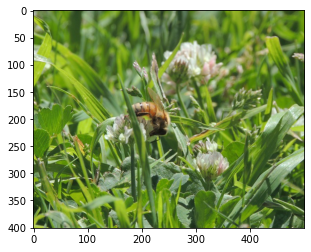

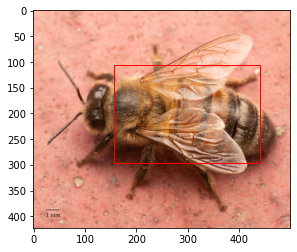

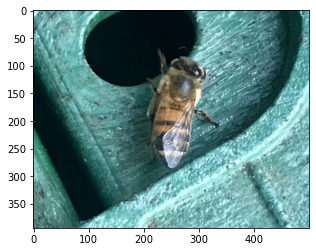

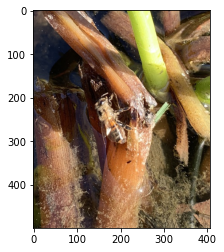

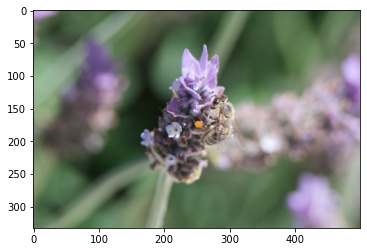

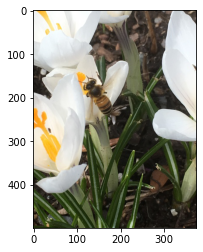

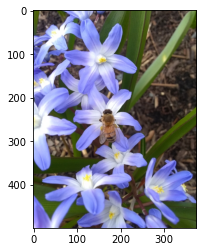

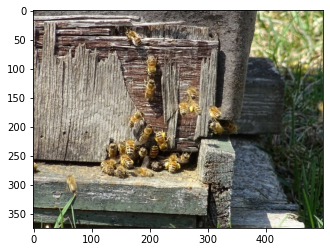

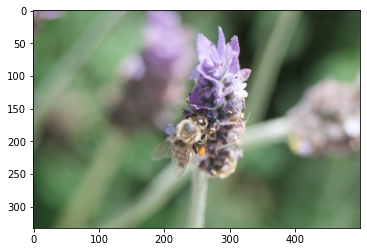

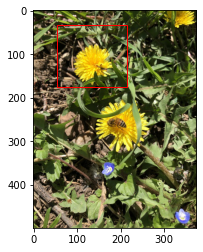

In [66]:
import matplotlib.pyplot as plt

endpoint_name='bees-detection-resnet50-ep-2021-04-20-01-07-50'

runtime_client = boto3.client('sagemaker-runtime')

# Call SageMaker endpoint to obtain predictions
def get_predictions_for_img(runtime_client, endpoint_name, img_path):
    with open(img_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)

    response = runtime_client.invoke_endpoint(EndpointName=endpoint_name, 
                                       ContentType='application/x-image', 
                                       Body=payload)

    result = response['Body'].read()
    result = json.loads(result)
    return result


# wait until the status has changed
client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
endpoint_response = client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
if status != 'InService':
    raise Exception('Endpoint creation failed.')

for test_image in test_images:
    result = get_predictions_for_img(runtime_client, endpoint_name, test_image)
    confidence_threshold = .5
    best_n = 1
    # display the best n predictions with confidence > confidence_threshold
    predictions = [prediction for prediction in result['prediction'] if prediction[1] > confidence_threshold]
    predictions.sort(reverse=True, key = lambda x: x[1])
    bboxes = [prediction_to_bbox_data(test_image, prediction) for prediction in predictions[:best_n]]
    show_annotated_image(test_image, bboxes)

<a name='cleanup'></a>
## Cleanup

At the end of the lab we would like to delete the real-time endpoint, as keeping a real-time endpoint around while being idle is costly and wasteful. 

In [67]:
client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'bcb64f8f-60b0-4709-ad37-152c4ab9b36b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bcb64f8f-60b0-4709-ad37-152c4ab9b36b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 20 Apr 2021 01:22:59 GMT'},
  'RetryAttempts': 0}}